In [1]:
import os
os.chdir('../')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.externals import joblib
from urllib import urlencode
import matplotlib.pyplot as plt
import lib.yelp_api as yp
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
import re

%matplotlib inline

In [3]:
yelp_df = pd.read_pickle('data/yelp_data_reviews.pkl')

In [4]:
yelp_df.head(1)

,search_name,search_address,bus_id,name,price,cat_1,cat_2,closed,address,city,...,author_rating_36,author_37,post_date_37,author_rating_37,author_38,post_date_38,author_rating_38,author_39,post_date_39,author_rating_39
101-asian-kitchen-los-angeles,WOK MASTER,7170 BEVERLY BLVD,101-asian-kitchen-los-angeles,101 Asian Kitchen,$$,chinese,sushi,False,7170 Beverly Blvd,Los Angeles,...,2.0,None,None,NaN,None,None,NaN,None,None,NaN


In [5]:
rest_df = pd.read_pickle('data/la_rest_group_df.pkl')

In [6]:
rest_df.head(1)

,facility,address,city,zip_cd,num_at_address,max_seats,phone,risk_level,last_inspect_date,inspect_score,cat,closed_est,year
0,#1 CAFE,2080 CENTURY PARK E,LOS ANGELES,90067,1,30,+1nan,3,2016-08-18,90.0,None,0,2016


In [7]:
cmplt_rest_df = pd.merge(rest_df, yelp_df, left_on=['facility', 'address'], 
                         right_on=['search_name', 'search_address'], how='left')

cmplt_rest_df.head()

,facility,address_x,city_x,zip_cd,num_at_address,max_seats,phone,risk_level,last_inspect_date,inspect_score,...,author_rating_36,author_37,post_date_37,author_rating_37,author_38,post_date_38,author_rating_38,author_39,post_date_39,author_rating_39
0,#1 CAFE,2080 CENTURY PARK E,LOS ANGELES,90067,1,30,+1nan,3,2016-08-18,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#1 CHINESE FAST FOOD,8606 S VERMONT AVE,LOS ANGELES,90044,1,30,+12132358779,3,2016-08-10,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#1 DONUT,8509 S FIGUEROA ST,LOS ANGELES,90003,2,30,+1nan,2,2016-05-17,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#1 DONUTS,8509 S FIGUEROA ST,LOS ANGELES,90003,2,30,+16266957898,2,2016-07-26,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#2 MOON BBQ,478 N WESTERN AVE,LOS ANGELES,90004,1,150,+13234656707,3,2016-10-12,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
post_cols = ['post_date_' + str(i) for i in range(0,40)]

In [9]:
for col in post_cols:
    cmplt_rest_df[col] = pd.to_datetime(cmplt_rest_df[col], format="%Y-%m-%d")

In [10]:
cmplt_rest_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9549 entries, 0 to 9548
Columns: 148 entries, facility to author_rating_39
dtypes: datetime64[ns](41), float64(45), int64(5), object(57)
memory usage: 10.9+ MB


In [11]:
cmplt_rest_df['max_rvw_dt'] = cmplt_rest_df[post_cols].max(axis=1).astype('datetime64[ns]')
cmplt_rest_df['min_rvw_dt'] = cmplt_rest_df[post_cols].min(axis=1).astype('datetime64[ns]')
cmplt_rest_df['est_rst_open'] = cmplt_rest_df['max_rvw_dt'] - cmplt_rest_df['min_rvw_dt']

In [12]:
auth_cols = ['author_' + str(i) for i in range(0,40)]

In [13]:
def replc_chars(x):
    try:
        return str(x)
    except:
        return 'auth_rplc'

In [14]:
for col in auth_cols:
    cmplt_rest_df[col] = cmplt_rest_df[col].apply(replc_chars)

In [15]:
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'ñ', 'n')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'Ü', 'u')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'é', 'e')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'è', 'e')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'ö', 'o')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'à', 'a')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'ä', 'a')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'ō', 'o')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'¢', 'c')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'ó', 'o')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'ú', 'u')
cmplt_rest_df['name'] = cmplt_rest_df['name'].str.replace(u'ü', 'u')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'ü', 'u')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'ñ', 'n')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'Ü', 'u')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'é', 'e')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'è', 'e')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'ö', 'o')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'à', 'a')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'ä', 'a')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'ō', 'o')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'¢', 'c')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'ó', 'o')
cmplt_rest_df['bus_id'] = cmplt_rest_df['bus_id'].str.replace(u'ú', 'u')

In [34]:
cmplt_rest_df['avg_rating'] = cmplt_rest_df['avg_rating'].fillna(value=0)
cmplt_rest_df['est_rst_open'] = cmplt_rest_df['est_rst_open'].fillna(value=0)
cmplt_rest_df['est_rst_open'] = cmplt_rest_df['est_rst_open'].apply(lambda x: x.days)

In [35]:
ylp_lacnty_df = cmplt_rest_df[cmplt_rest_df['name'] > 0]

In [36]:
ylp_lacnty_df.head()

,facility,address_x,city_x,zip_cd,num_at_address,max_seats,phone,risk_level,last_inspect_date,inspect_score,...,author_rating_37,author_38,post_date_38,author_rating_38,author_39,post_date_39,author_rating_39,max_rvw_dt,min_rvw_dt,est_rst_open
4,#2 MOON BBQ,478 N WESTERN AVE,LOS ANGELES,90004,1,150,+13234656707,3,2016-10-12,92.0,...,NaN,None,NaT,NaN,None,NaT,NaN,2012-09-17,2012-09-17,0
5,#2 MOON BBQ,478 N WESTERN AVE,LOS ANGELES,90004,1,150,+13234656707,3,2016-10-12,92.0,...,1.0,Martin E.,2017-01-05,1.0,Deedee C.,2016-12-26,5.0,2017-03-01,2012-04-29,1767
9,1 WOK,5565 W MANCHESTER AVE,LOS ANGELES,90045,2,30,+13105689192,3,2016-12-08,92.0,...,5.0,Reese M.,2013-01-30,3.0,Dan G.,2011-08-16,3.0,2017-01-13,2010-03-21,2490
14,10880 WILSHIRE TRIMANA,10880 WILSHIRE BLVD,LOS ANGELES,90024,1,60,+13104703683,3,2016-10-25,98.0,...,NaN,None,NaT,NaN,None,NaT,NaN,2017-02-08,2009-07-13,2767
16,1632THAI SILK EXPRESS,1260 S SOTO ST,LOS ANGELES,90023,6,30,+13232684695,3,2016-09-23,93.0,...,4.0,Mallory S.,2013-09-01,4.0,Ana H.,2016-07-07,1.0,2017-03-03,2009-12-21,2629


In [37]:
ylp_lacnty_df = ylp_lacnty_df[['bus_id', 'search_name', 'name', 'search_address',  
                               'address_y', 'max_seats', 'risk_level', 'inspect_score', 
                               'price', 'cat_1', 'cat_2', 'zip_code',
                               'latitude', 'longitude', 'num_reviews', 'avg_rating',
                               'min_rvw_dt', 'max_rvw_dt', 'est_rst_open', 'closed']]

In [38]:
pd.DataFrame.to_csv(ylp_lacnty_df, 'data/tableau_cmplt_data.csv')

## EDA

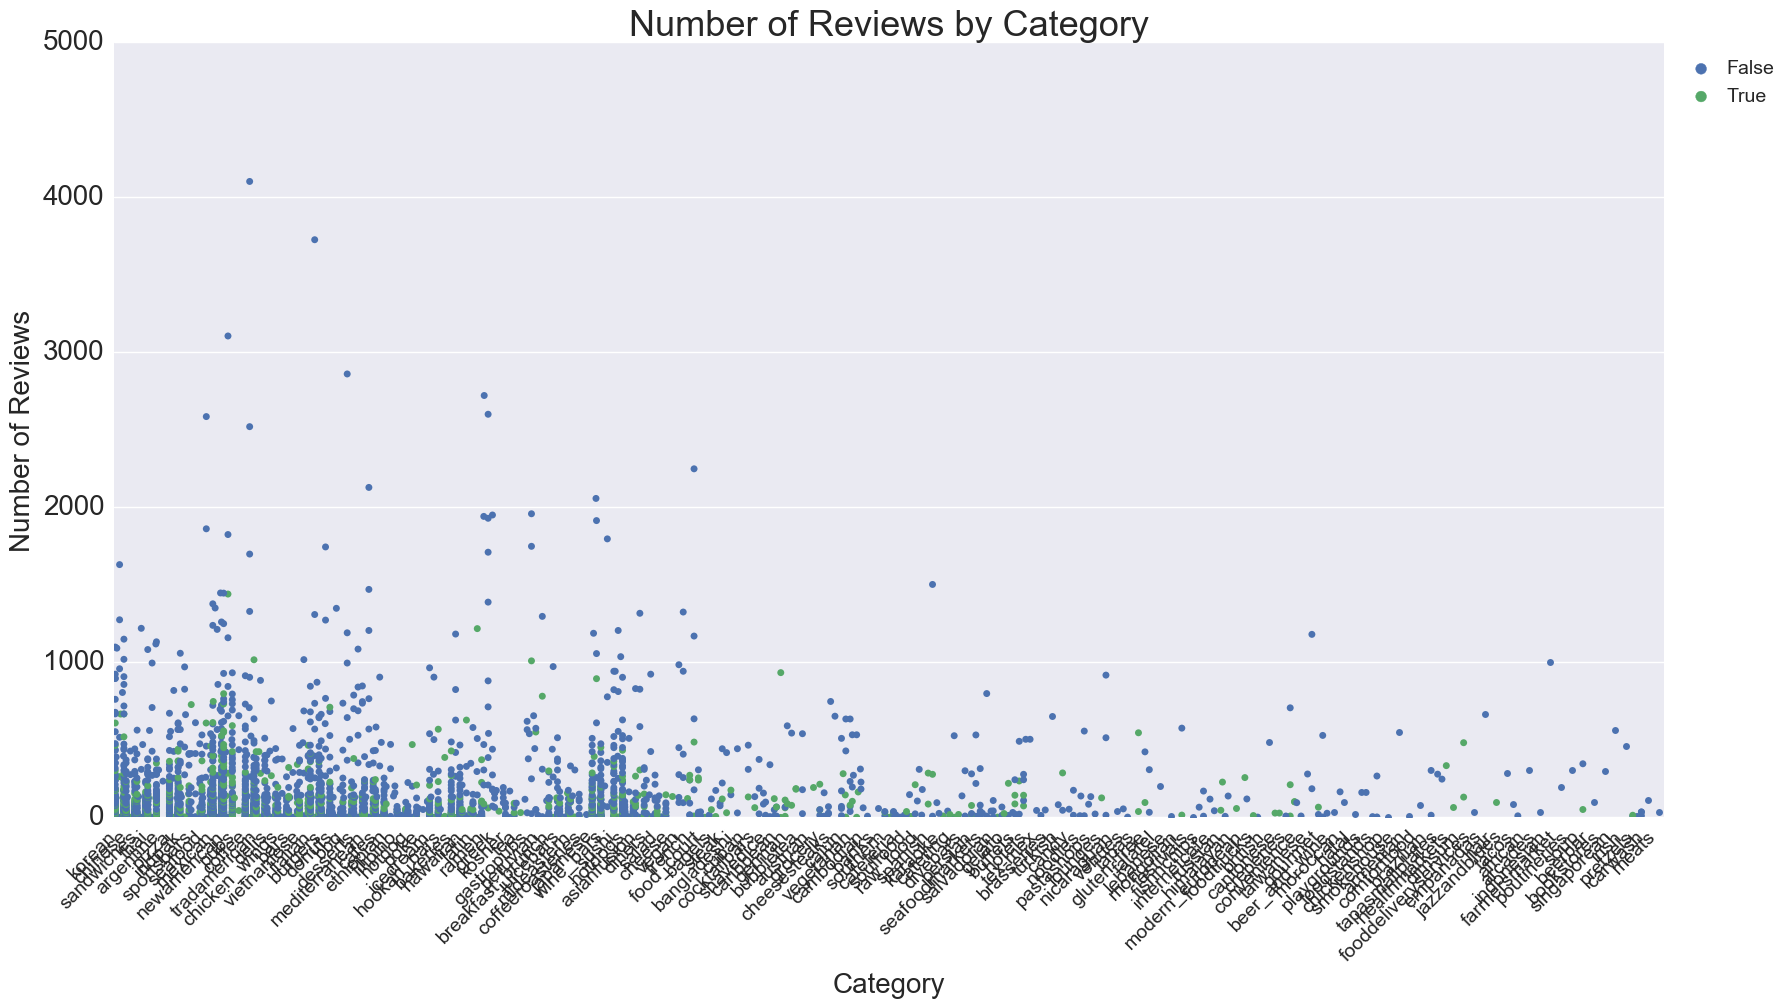

,cat_1,name,num_reviews
860,italian,Bottega Louie,12873.0
9028,coffee,Urth Caffe - Downtown LA,4103.0
639,italian,Bestia,3727.0
5225,newamerican,Masa of Echo Park,3106.0
436,bbq,Kang Ho-dong Baekjeong,2861.0
6074,ramen,Orochon Ramen,2722.0
8945,ramen,Tsujita LA Artisan Noodle,2601.0
2643,seafood,EMC Seafood & Raw Bar,2586.0
8654,coffee,The Pie Hole,2521.0
6881,french,Republique,2249.0


In [20]:
fig = plt.figure(figsize=(20,10))

sns.swarmplot(x='cat_1', y='num_reviews', hue='closed', data=ylp_lacnty_df)
plt.xlabel('Category', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=20)
plt.ylabel('Number of Reviews', fontsize=20)
plt.ylim(0, 5000)
plt.title('Number of Reviews by Category', fontsize=26)
plt.legend(bbox_to_anchor = (1, 1), loc = 2, handletextpad = 0.3, fontsize=14)
plt.show()

ylp_lacnty_df[['cat_1', 'name', 'num_reviews']].sort_values('num_reviews', ascending=False).head(10)

(0, 3000)

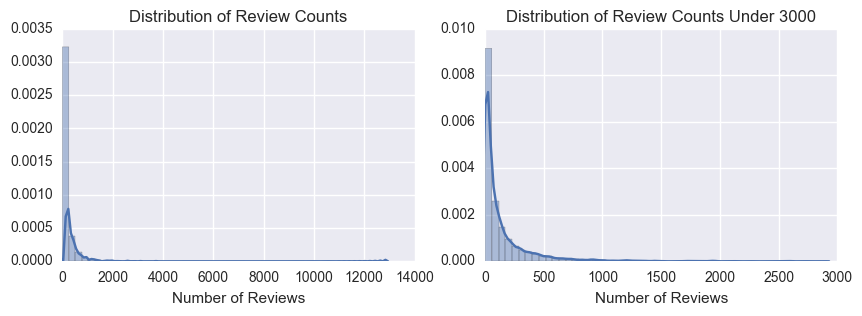

In [39]:
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,2,1)
sns.distplot(ylp_lacnty_df['num_reviews'])
plt.xlabel('Number of Reviews')
plt.title('Distribution of Review Counts')
plt.xlim(0, 14000)

fig.add_subplot(1,2,2)
sns.distplot(ylp_lacnty_df[ylp_lacnty_df['num_reviews'] < 3000]['num_reviews'])
plt.xlabel('Number of Reviews')
plt.title('Distribution of Review Counts Under 3000')
plt.xlim(0,3000)

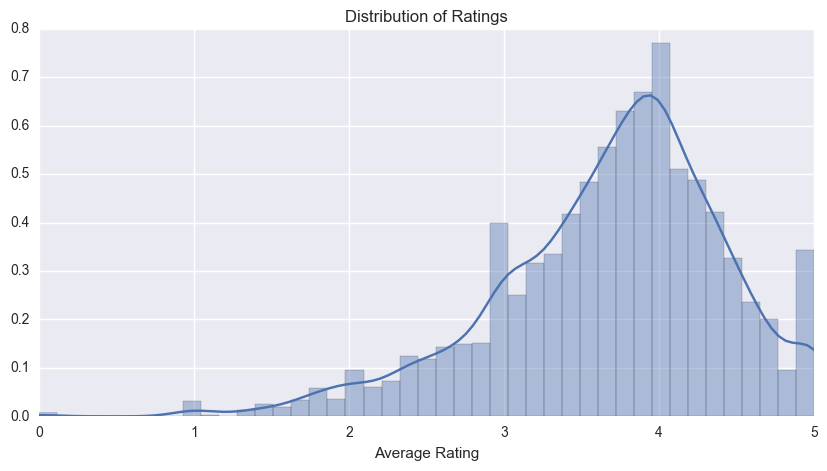

In [40]:
plt.figure(figsize=(10,5))

sns.distplot(ylp_lacnty_df['avg_rating'])
plt.xlabel('Average Rating')
plt.title('Distribution of Ratings')
plt.xlim(0,5)
plt.show()

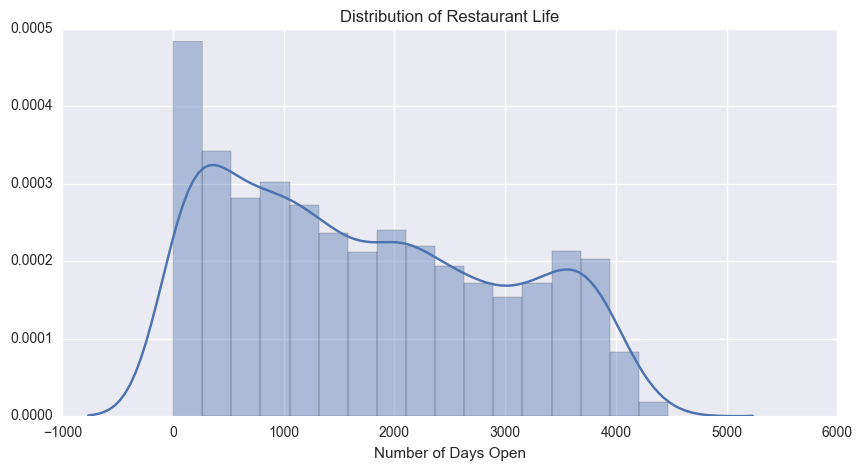

In [44]:
plt.figure(figsize=(10,5))

sns.distplot(ylp_lacnty_df['est_rst_open'])
plt.xlabel('Number of Days Open')
plt.title('Distribution of Restaurant Life')
plt.show()

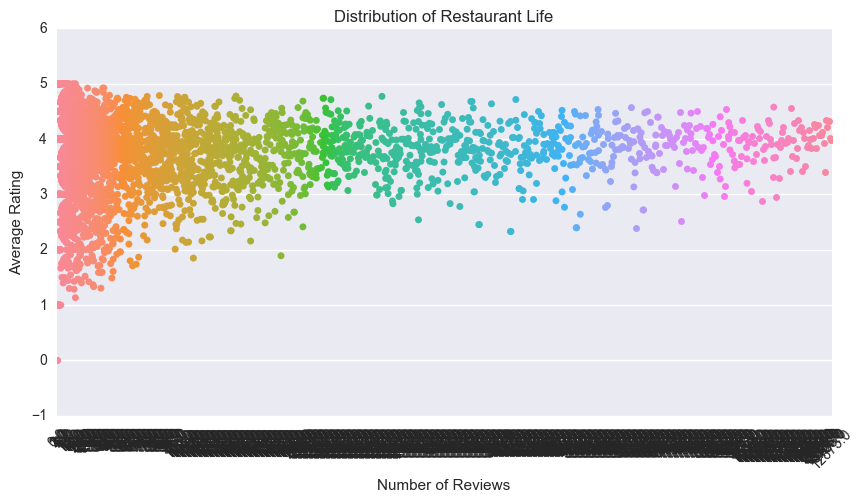

In [64]:
plt.figure(figsize=(10,5))

ylp_lacnty_df.sort_values('num_reviews', inplace=True)

sns.swarmplot(ylp_lacnty_df['num_reviews'], ylp_lacnty_df['avg_rating'])
plt.xticks(rotation=45)
plt.xlabel('Number of Reviews')
plt.ylabel('Average Rating')
plt.title('Distribution of Restaurant Life')
plt.show()